# Initialization


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.exceptions import DataConversionWarning


Hiding data conversion warnings generated by standard scaler.
Standard scaler expects float as input and converts input to float throwing a warning message.

In [2]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


Reading part (1/n) of the data

In [3]:
def skiprow(i, n):
    if i % n == 0:
       return False
    return True


Change n to load more, or less of the data.

In [4]:
n=1
train_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_train.csv.zip?raw=true'
test_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_test.csv.zip?raw=true'
train = pd.read_csv(train_url, compression='zip', skiprows = lambda x: skiprow(x, n))
test = pd.read_csv(test_url, compression='zip' , skiprows = lambda x: skiprow(x, 1))

train.shape

(6000, 785)

In [5]:
train.sample(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1116,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3559,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

In [6]:
y_train=train.label.values
X_train=train.drop('label', axis=1).values
X_test = test.drop('label', axis=1).values
y_test = test.label.values

# Define models

Multi label models.

In [7]:
models = []
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('Linear SVM', SVC(gamma='scale', C=1, decision_function_shape='ovo')))
models.append(('Neural Net', MLPClassifier(alpha=0.0001, solver='sgd')))
#models.append(('XGB', XGBClassifier(objective='multi:softmax', num_class=10)))
models.append(('LR', LogisticRegression(solver="saga", multi_class="multinomial", max_iter=1000))) # ovr - one versus reset
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10)))


# Model fitting and prediction

In [8]:
def model_score(model, X, y):
    score = model.score(X, y)
    return score

In [9]:
def model_fit(model, X_train, y_train):
    cv_scores = []
    kfold = StratifiedKFold(n_splits=50, shuffle=True)
    for train, val in kfold.split(X_train, y_train):
        model.fit(X_train[train], y_train[train])
        cv_score = model_score(model, X_train[val], y_train[val])
        print("Validation score for classifier... %.4f" % cv_score)
        cv_scores.append(cv_score)
    return cv_scores

## Comparaing model performance on scaled and unscaled features
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [10]:
def cv_fit_and_predict(models, X_train, y_train, X_test, y_test):
    results = []
    val_results = []
    for name, model in models:
        print("Processing model: ", name)
        clf = make_pipeline(StandardScaler(), model)
 
        print("Un-scaled model...")
        cv_scores = model_fit(model, X_train, y_train)
        val_results.append((name+"_U", cv_scores))
        print("Scaled model...")
        cv_scores = model_fit(clf, X_train, y_train)
        val_results.append((name, cv_scores))

        print("Generating test scores for classifier... ")
        score = model_score(model, X_test, y_test)
        print("Test score for un-scaled classifier... %.4f" % score)
        results.append((name+"_U", score))
        score = model_score(clf, X_test, y_test)
        print("Test score for scaled classifier... %.4f" % score)
        results.append((name, score))
    print("Done")
    return results, val_results


In [11]:
results, val_results = cv_fit_and_predict(models, X_train, y_train, X_test, y_test)

Processing model:  KNN
Un-scaled model...
Validation score for classifier...  0.9617940199335548
Validation score for classifier...  0.9492934330839568
Validation score for classifier...  0.965
Validation score for classifier...  0.9565943238731218
Validation score for classifier...  0.9631799163179916
Scaled model...
Validation score for classifier...  0.9244186046511628
Validation score for classifier...  0.9185369908561929
Validation score for classifier...  0.93
Validation score for classifier...  0.9215358931552587
Validation score for classifier...  0.9238493723849373
Generating test scores for classifier... 
Test score for un-scaled classifier...  0.7917
Test score for scaled classifier...  0.8683
Processing model:  Linear SVM
Un-scaled model...
Validation score for classifier...  0.16528239202657807
Validation score for classifier...  0.16043225270157938
Validation score for classifier...  0.16166666666666665
Validation score for classifier...  0.1652754590984975
Validation sco

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.8272425249169435


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.8478802992518704
Validation score for classifier...  0.8916666666666667
Validation score for classifier...  0.5609348914858097
Validation score for classifier...  0.5631799163179916
Scaled model...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.946843853820598


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.9393183707398172


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.9341666666666667


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.9507512520868113


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for classifier...  0.9472803347280335
Generating test scores for classifier... 
Test score for un-scaled classifier...  0.7767
Test score for scaled classifier...  0.9029
Processing model:  LR
Un-scaled model...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9210963455149501


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9226932668329177


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9066666666666666


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9240400667779632


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9322175732217574
Scaled model...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9194352159468439


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9243557772236076


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9158333333333334


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9248747913188647


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Validation score for classifier...  0.9205020920502092
Generating test scores for classifier... 
Test score for un-scaled classifier...  0.737
Test score for scaled classifier...  0.8714
Processing model:  RF
Un-scaled model...
Validation score for classifier...  0.8571428571428571
Validation score for classifier...  0.8478802992518704
Validation score for classifier...  0.8408333333333333
Validation score for classifier...  0.8397328881469115
Validation score for classifier...  0.8368200836820083
Scaled model...
Validation score for classifier...  0.845514950166113
Validation score for classifier...  0.8437240232751455
Validation score for classifier...  0.8383333333333334
Validation score for classifier...  0.830550918196995
Validation score for classifier...  0.8376569037656904
Generating test scores for classifier... 
Test score for un-scaled classifier...  0.1156
Test score for scaled classifier...  0.7749
Done


# Validation and results

In [12]:
np_results=np.array(results, object)
np_val=np.array(val_results, object)

In [13]:
def plot_model_validation(results):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model score')
    plt.show()
    
    return 0

In [14]:
def plot_model_test(results):
    plt.bar(results[:, 0], results[:, 1])
    plt.xticks(results[:,0])
    plt.title('Model score')
    plt.show()
    
    return 0

Compare results for models and unscaled models (with _U).

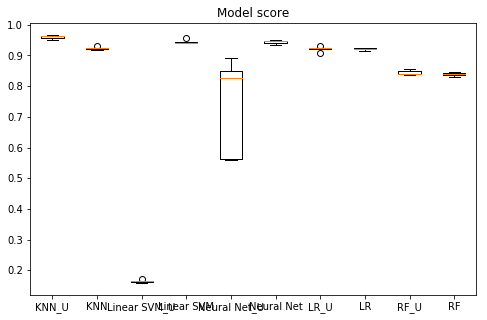

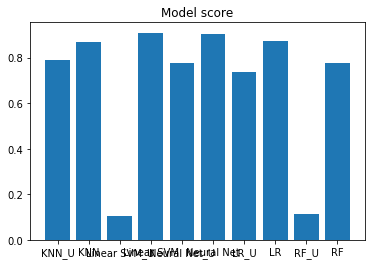

In [15]:
status = plot_model_validation(np_val)
status = plot_model_test(np_results)